<a href="https://colab.research.google.com/github/leonardosva/mvp_cnh/blob/main/MVP_CNH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP - Renovação Carteira Nacional de Habilitação - CNH #

# Definição do Problema

**Descrição do problema**

As regras para renovação da CNH mudaram em dezembro de 2021, de acordo com a Lei nº 14.404/2022. Agora, o prazo de validade da CNH varia de acordo com a idade do condutor.  

**Nova regra para renovação de CNH:**

Idade do motorista ----  Validade

*   Até 49 anos--------------10 anos.
*   Entre 50 e 69 anos-------5 anos.
*   Mais de 70 anos----------3 anos.

Entretando ainda existem carteiras CNH emitidas com base na regra Lei anterior - Validade 5 anos.

- A ideia é analisar preditivamente os contudores com CNH's validas / vencidas e identificar o fluxo de renovação dentro do prazo legal de acordo com a Lei anterior. ( 5 anos )

Utilizei modelos de acordo com as aulas de machine learning para analisar/tratar o problema de classificação.

**DATASET**

 O dataset possui 10000 instâncias e 5 atributos, entre dados categóricos e numéricos:

Colunas:
- IDADE: idade do condutor
- CATEGORIA: categoria da cnh (B, A, AB, AD )
- TIPO: Condutor (C) ou Permissionario (P).
- EMISSAO: Data da emissão da CNH.
- VALIDADE: Data da validade da CNH.
- RENOVACAO: Classe de saída: 0 - RENOVAR e 1 - NAO RENOVAR










***Realizar as importações das bibliotecas necessárias para o projeto***

In [ ]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports de bibliotecas necessárias
import pandas as pd # Usamos o pandas para importação do dataset
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from imblearn.over_sampling import SMOTE # Oversampling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler # ajuste de escalonamento
from sklearn.preprocessing import LabelEncoder # converção de variáveis categóticas
from sklearn.model_selection import train_test_split # Divide a base de treino e teste (holdout)
from sklearn.model_selection import KFold # folds da validação cruzada
from sklearn.model_selection import StratifiedKFold # estratificação dos Kfolds
from sklearn.model_selection import cross_val_score # validação cruzada
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score # acurácia do modelo
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # matriz de confusão
from sklearn.pipeline import Pipeline #criação dos pipelines
from sklearn.linear_model import LogisticRegression # algorítmo de regressão logistica
from sklearn.tree import DecisionTreeClassifier # algorítmos arvore de classificação
from sklearn.neighbors import KNeighborsClassifier # algorítmos KNN
from sklearn.naive_bayes import GaussianNB # algoritmo Naive Bayes
from sklearn.svm import SVC # algoritmo SVC
from sklearn.ensemble import BaggingClassifier # ensemble Bagging
from sklearn.ensemble import RandomForestClassifier # ensemble RF
from sklearn.ensemble import ExtraTreesClassifier # ensemble ExtraTree
from sklearn.ensemble import VotingClassifier # ensemblre Voting
from sklearn.ensemble import AdaBoostClassifier # ensembel ADA Boost
from sklearn.ensemble import GradientBoostingClassifier # ensemble GradientBoost
from sklearn.ensemble import HistGradientBoostingClassifier # ensemble GradientBoost
from statistics import mean

***Carregando dataset com dados de estudo/analise dos condutores CNH***

In [ ]:
# Carregando dataset

url = "https://raw.githubusercontent.com/leonardosva/mvp_cnh/main/dataset_cnh.csv"
data_cnh = pd.read_csv(url, delimiter=';') # leitura do dataset CNH
data_cnh.head(10) # exibição das 10 primeiras linhas do dataset CNH

,IDADE,CATEGORIA,TIPO,EMISSAO,VALIDADE,RENOVACAO
0,60,AD,C,02/10/2004,30/09/2009,1
1,51,B,C,02/10/2004,30/09/2009,1
2,56,B,C,02/10/2004,30/09/2009,1
3,74,B,C,02/10/2004,30/09/2009,1
4,50,C,C,02/10/2004,30/09/2009,1
5,71,AC,C,02/10/2004,30/09/2009,1
6,44,B,C,02/10/2004,30/09/2009,1
7,73,AB,C,02/10/2004,30/09/2009,1
8,50,B,C,02/10/2004,30/09/2009,1
9,-24,B,C,02/10/2004,30/09/2009,1


***Verificando o desbalanceamento e discrepâncias do Datast CNH***

In [ ]:
# Verificando o desbalanceamento e discrepâncias do Datast CNH
data_cnh.describe()

,IDADE,RENOVACAO
count,8000.000000,8000.000000
mean,48.242625,0.625000
std,22.869825,0.484153
min,-25.000000,0.000000
25%,45.000000,0.000000
50%,54.000000,1.000000
75%,61.000000,1.000000
max,74.000000,1.000000


***Podemos observar um desvio em relação a idade (idade negativa), lei vigente permitem CNH apenas para maiores de 18 anos.***

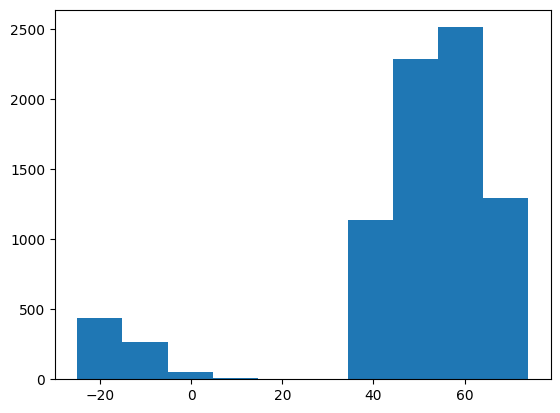

In [ ]:
# Plotando a distribuição da idade em relação a base CNH
plt.hist(x=data_cnh['IDADE']);

***Tratativas de valores divergentes no Dataset CNH***
- Após análise dos dados, realizaremos o tratamento de valores divergentes . No caso, encontramos algumas idades inferior a 18.

In [ ]:
# Filtragem das idade negativas
data_cnh[data_cnh['IDADE'] <= 17]

,IDADE,CATEGORIA,TIPO,EMISSAO,RENOVACAO
9,-24,B,C,02/10/2004,1
13,-25,C,C,02/10/2004,1
16,-20,C,C,02/10/2004,1
26,-11,C,C,02/10/2004,1
30,-12,B,C,02/10/2004,1
...,...,...,...,...,...
4934,-24,C,C,08/10/2004,1
4945,-24,D,C,08/10/2004,1
4960,-14,B,C,08/10/2004,1
4965,-22,D,C,08/10/2004,1


In [ ]:
# Adotaremos Idade > 17  para correção sem considerar os valores idade < 18
drop = data_cnh[data_cnh['IDADE']<18].index
data_cnh = data_cnh.drop(drop,axis=0)

In [ ]:
# Exibindo o dataset CNH sem idade negativas
data_cnh.describe()

,IDADE,RENOVACAO
count,7233.000000,7233.000000
mean,55.126642,0.585234
std,8.878435,0.492716
min,38.000000,0.000000
25%,49.000000,0.000000
50%,55.000000,1.000000
75%,62.000000,1.000000
max,74.000000,1.000000


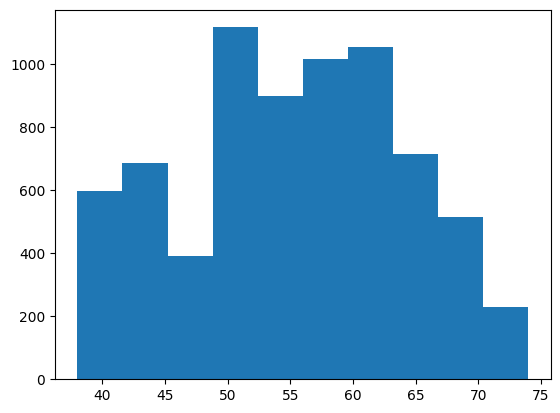

In [ ]:
# Plotando a distribuição da idade em relação a base após a correção
plt.hist(x=data_cnh['IDADE']);

***Verificando a existência de campos nulos.***

In [ ]:
# Buscar null em todos os registros
data_cnh.isnull().sum()

IDADE        0
CATEGORIA    0
TIPO         0
EMISSAO      0
RENOVACAO    0
dtype: int64

***Analisando o balanceamento por Oversampling***

In [ ]:
# Funcão para contar os valores únicos da coluna "RENOVACAO" e verificar o balanceamento
np.unique(data_cnh['RENOVACAO'], return_counts=True)

(array([0, 1]), array([3000, 4233]))

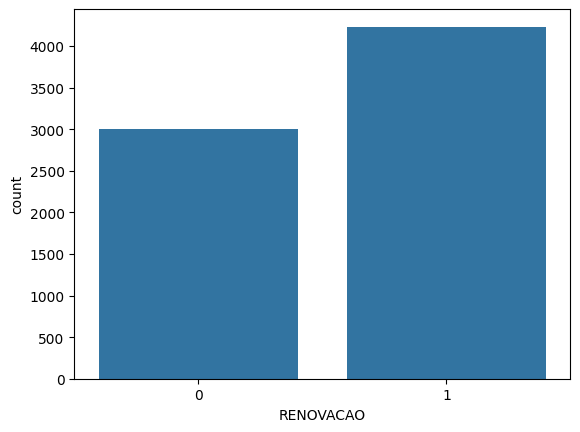

In [ ]:
# Plotando em gráfico o balanceamento
sns.countplot(x=data_cnh['RENOVACAO']);

In [ ]:
# Divisão entre previsores e classes
X_cnh = data_cnh.drop('RENOVACAO', axis=1)
y_cnh = data_cnh[['RENOVACAO']]

# Codificar variáveis categóricas
label_encoder_tipo = LabelEncoder()
label_encoder_cat = LabelEncoder()
label_encoder_emissao = LabelEncoder()
label_encoder_validade = LabelEncoder()

X_cnh.iloc[:,1] = label_encoder_tipo.fit_transform(X_cnh.iloc[:,1])
X_cnh.iloc[:,2] = label_encoder_cat.fit_transform(X_cnh.iloc[:,2])
X_cnh.iloc[:,3] = label_encoder_emissao.fit_transform(X_cnh.iloc[:,3])
X_cnh.iloc[:,4] = label_encoder_validade.fit_transform(X_cnh.iloc[:,4])

# Holdout
X_cnh_training, X_cnh_test, y_cnh_training, y_cnh_test = train_test_split(X_cnh, y_cnh)


In [ ]:
# Funcão para validação cruzada
def cross_validation(model, X_cnh, y_cnh, oversampling=False):
    kfold = KFold(n_splits=10)

    # lista de acurácias dos splits
    accuracy_split = []

    for idx,(idx_training, idx_validation) in enumerate(kfold.split(X_cnh)):
        X_split_training = X_cnh.iloc[idx_training,:]
        y_split_training = y_cnh.iloc[idx_training,:]

        # oversampling, só no split de treino!
        if oversampling:
            sm = SMOTE(random_state=42)
            X_split_training, y_split_training = sm.fit_resample(X_split_training, y_split_training)

        # Treinando o modelo
        model.fit(X_split_training, y_split_training.values.flatten())

        X_split_validation = X_cnh.iloc[idx_validation, :]
        y_split_validation = y_cnh.iloc[idx_validation, :]

        # Validação SEM oversampling
        predict_validation = model.predict(X_split_validation)

        acuracia_split = accuracy_score(y_split_validation, predict_validation)

        accuracy_split.append(acuracia_split)

        print(f'Acurácia do split {idx}: {accuracy_split}')
    return accuracy_split

In [ ]:
# Criando um modelo
model_hgb = HistGradientBoostingClassifier()

mean_accuracy_with_smote = mean(cross_validation(model_hgb, X_cnh_training, y_cnh_training, oversampling=False))
mean_accuracy_no_smote = mean(cross_validation(model_hgb, X_cnh_training, y_cnh_training, oversampling=True))

f'No smote: {mean_accuracy_no_smote:.02f}, with_smo: {mean_accuracy_with_smote:.02f}'

Acurácia do split 0: [1.0]
Acurácia do split 1: [1.0, 1.0]
Acurácia do split 2: [1.0, 1.0, 1.0]
Acurácia do split 3: [1.0, 1.0, 1.0, 0.998158379373849]
Acurácia do split 4: [1.0, 1.0, 1.0, 0.998158379373849, 0.9981549815498155]
Acurácia do split 5: [1.0, 1.0, 1.0, 0.998158379373849, 0.9981549815498155, 1.0]
Acurácia do split 6: [1.0, 1.0, 1.0, 0.998158379373849, 0.9981549815498155, 1.0, 1.0]
Acurácia do split 7: [1.0, 1.0, 1.0, 0.998158379373849, 0.9981549815498155, 1.0, 1.0, 0.9981549815498155]
Acurácia do split 8: [1.0, 1.0, 1.0, 0.998158379373849, 0.9981549815498155, 1.0, 1.0, 0.9981549815498155, 1.0]
Acurácia do split 9: [1.0, 1.0, 1.0, 0.998158379373849, 0.9981549815498155, 1.0, 1.0, 0.9981549815498155, 1.0, 1.0]
Acurácia do split 0: [1.0]
Acurácia do split 1: [1.0, 1.0]
Acurácia do split 2: [1.0, 1.0, 1.0]
Acurácia do split 3: [1.0, 1.0, 1.0, 0.998158379373849]
Acurácia do split 4: [1.0, 1.0, 1.0, 0.998158379373849, 1.0]
Acurácia do split 5: [1.0, 1.0, 1.0, 0.998158379373849, 1.0

'No smote: 1.00, with_smo: 1.00'

- Com Oversampling = 1.00
- Sem Oversampling = 1.00

** Utilizando uma base de treinamento isolada, aplicamos Oversampling, que consiste em gerar novos exemplos para a classe minoritária, de forma a aumentar sua representatividade no conjunto de dados.

Observei que o algoritmo atingiu 100% de eficacia.



**Divisão das bases em treinamento e teste. No caso, dividiremos a base de treinamento em 70% e teste com 30%.**

In [ ]:
# Divisão das bases de treinamento e teste
# Transformando as variáveis para numpy
X_cnh = X_cnh.values
y_cnh = y_cnh.values
X_cnh_training, X_cnh_test, y_cnh_training, y_cnh_test = train_test_split(X_cnh, y_cnh, test_size=0.30, random_state=10) #
X_cnh_training.shape, y_cnh_training.shape # Exibindo a dimensionalidade da base de treinamento

((5063, 4), (5063, 1))

In [ ]:
# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=10) # validação cruzada com estratificação

LR: 0.808417 (0.013325)
KNN: 0.952203 (0.006824)
CART: 0.999803 (0.000592)
NB: 0.554025 (0.016444)
SVM: 0.829944 (0.016021)
Bagging: 0.999606 (0.000789)
RF: 0.999606 (0.000789)
ET: 0.999606 (0.000789)
Ada: 1.000000 (0.000000)
GB: 0.999803 (0.000592)
Voting: 0.869643 (0.012521)


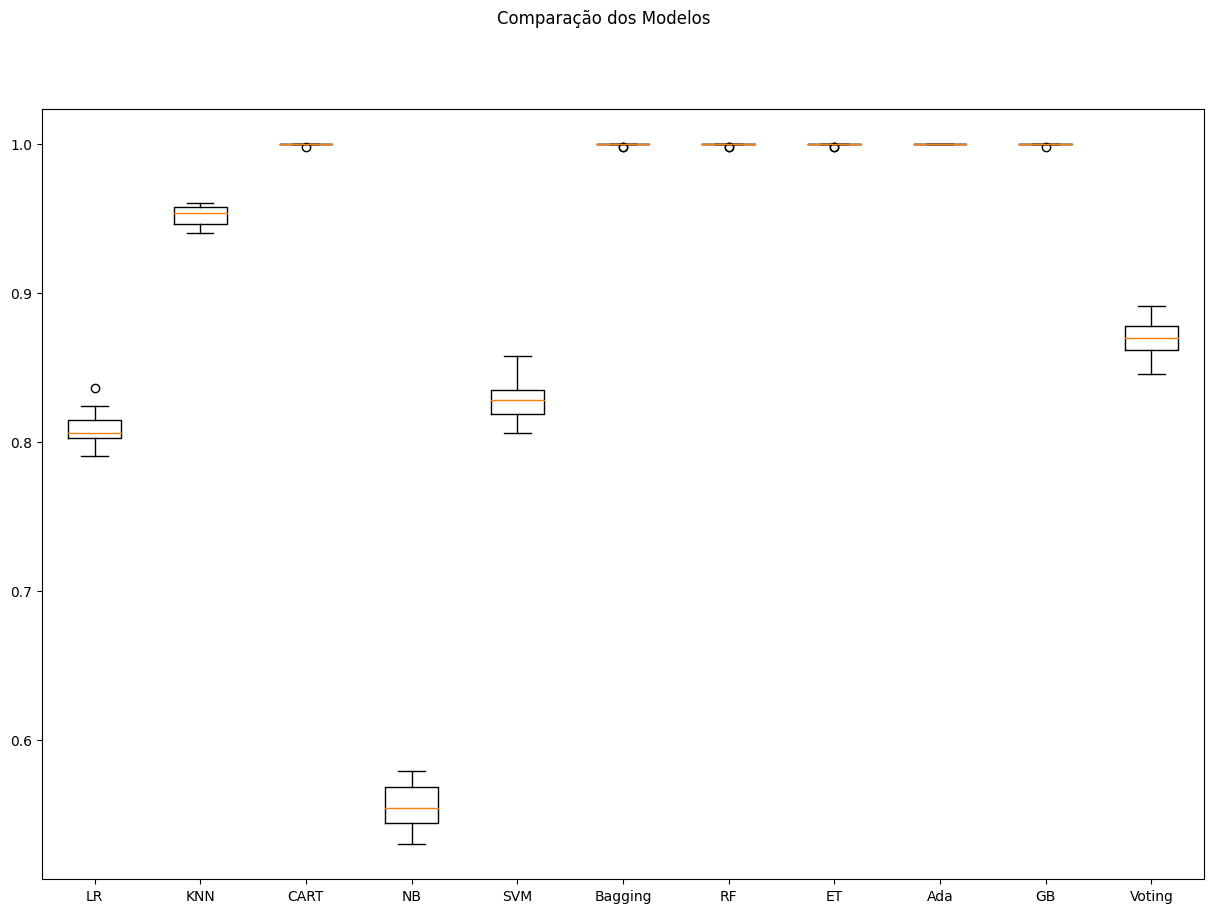

In [ ]:
# Modelagem e Inferência
# Criação e avaliação de modelos: linha base
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_cnh_training, y_cnh_training, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)



# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

***Observamos que o treinamento e avaliação dos modelos de linha de base, e já tivemos 100% para o AdaBoostClassifier. Desda forma ja atenderia sem a necessidade de padronização ou normalização. Como foi solicitado no checklist do MVP, manterei o restante das avaliações, conforme abaixo.   ***

LR-orig: 0.808 (0.013)
KNN-orig: 0.952 (0.007)
CART-orig: 1.000 (0.001)
NB-orig: 0.554 (0.016)
SVM-orig: 0.830 (0.016)
Bag-orig: 1.000 (0.001)
RF-orig: 1.000 (0.001)
ET-orig: 1.000 (0.001)
Ada-orig: 1.000 (0.000)
GB-orig: 1.000 (0.001)
Vot-orig: 0.870 (0.013)
LR-padr: 0.808 (0.014)
KNN-padr: 0.942 (0.011)
CART-padr: 1.000 (0.001)
NB-padr: 0.554 (0.016)
SVM-padr: 0.838 (0.012)
Bag-padr: 1.000 (0.001)
RF-padr: 1.000 (0.001)
ET-padr: 1.000 (0.001)
Ada-padr: 1.000 (0.000)
GB-padr: 1.000 (0.001)
Vot-padr: 0.872 (0.014)
LR-norm: 0.810 (0.013)
KNN-norm: 0.944 (0.007)
CART-norm: 1.000 (0.001)
NB-norm: 0.554 (0.016)
SVM-norm: 0.847 (0.017)
Bag-norm: 1.000 (0.001)
RF-norm: 1.000 (0.001)
ET-norm: 1.000 (0.001)
Ada-norm: 1.000 (0.000)
GB-norm: 1.000 (0.001)
Vot-norm: 0.874 (0.014)


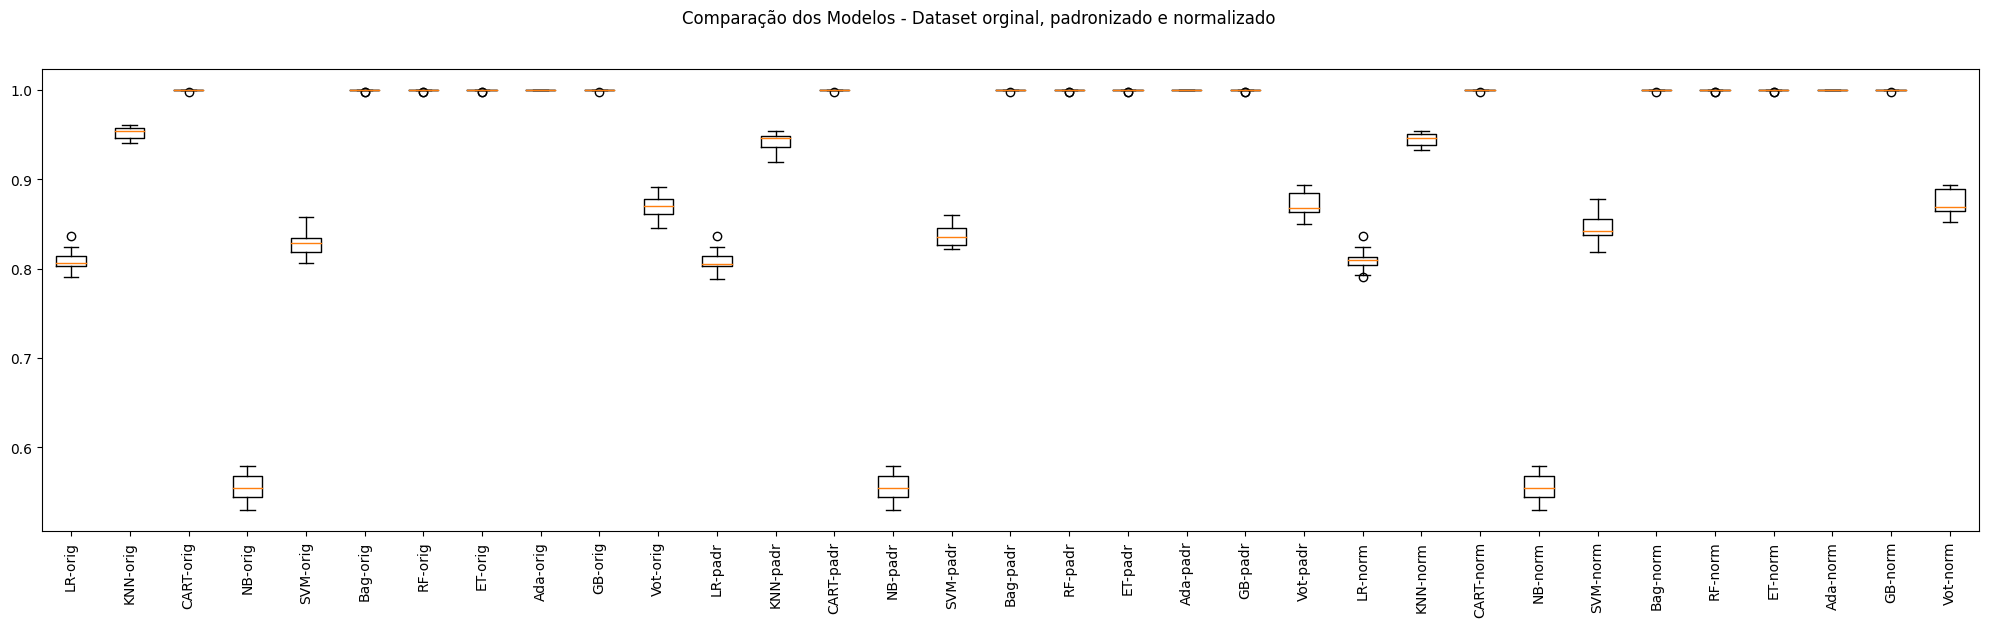

In [ ]:
# Criação e avaliação de modelos: dados padronizados e normalizados

np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())



# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_cnh_training, y_cnh_training, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

***Como exposto acima, estaremos seguindo com o restante da otimização dos hiperparametros, mesmo sem a necessidade, apenas para cumprir o proforma.***

In [ ]:
# Otimização dos hiperparâmetros
# Tuning do AdaBoostClassifier

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline

adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))

standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

#AdaBoostClassifier
pipelines.append(('Ada-orig', Pipeline(steps=[adaboost])))
pipelines.append(('Ada--padr', Pipeline(steps=[standard_scaler, adaboost])))
pipelines.append(('Ada--norm', Pipeline(steps=[min_max_scaler, adaboost])))

param_grid = {
     'Ada__n_estimators': [50,75,100],
     'Ada__learning_rate': [0.5, 1.0, 1.5],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_cnh_training, y_cnh_training)
    # imprime a melhor configuração
    #print("Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))
    print(name,grid.best_score_,grid.best_params_)

Ada-orig 1.0 {'Ada__learning_rate': 1.0, 'Ada__n_estimators': 75}
Ada--padr 1.0 {'Ada__learning_rate': 1.0, 'Ada__n_estimators': 75}
Ada--norm 1.0 {'Ada__learning_rate': 1.0, 'Ada__n_estimators': 75}


In [ ]:
# Finalização do Modelo
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_cnh_training) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_cnh_training) # aplicação da padronização no conjunto de treino
#model = RandomForestClassifier(n_estimators=100, max_features=1.0, criterion='log_loss', max_depth=15)
#model = BaggingClassifier(n_estimators=100, max_features=1.0, estimator=base, max_samples=5)
#model = GradientBoostingClassifier(n_estimators=100, max_features=1.0, max_depth=15)
model =  AdaBoostClassifier(n_estimators=num_trees)

model.fit(rescaledX, y_cnh_training)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_cnh_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_cnh_test, predictions))

1.0


In [ ]:
# Preparação do modelo com TODO o dataset CNH
scaler = StandardScaler().fit(X_cnh) # ajuste do scaler com TODO o dataset CNH
rescaledX = scaler.transform(X_cnh) # aplicação da padronização com TODO o dataset CNH
model.fit(rescaledX, y_cnh)

AdaBoostClassifier(n_estimators=100)

In [ ]:
# Matriz de confusão
confusion_matrix(y_cnh_test, predictions)

array([[ 885,    0],
       [   0, 1285]])

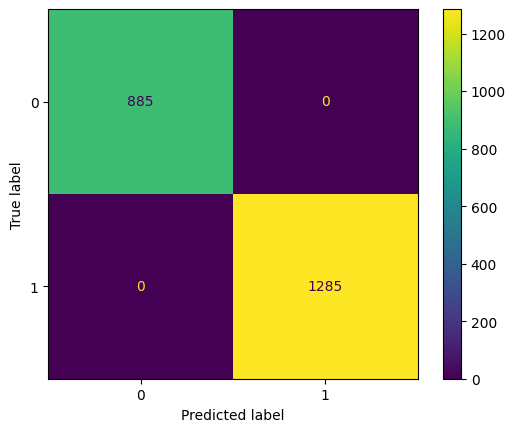

In [ ]:
# Visualizando através do gráfico da matriz de confusão
cm = confusion_matrix(y_cnh_test, predictions)
cm_display = ConfusionMatrixDisplay(cm).plot()

**Análise da Matriz de Confusão**

- Verdadeiro Positivo: 885 - Quando o classificador previu SIM (RENOVAR = 0) e a classe correta é SIM (RENOVAR=0)
- Verdadeiro Negativo: 1285 - Quando o classificador previu NÃO (RENOVAR = 1) e a classe correta é NÃO (REVOVAR=1)
- Falso Positivo: 0 - Quando o classificador previu SIM (RENOVAR = 0) e a classe correta é NÃO (RENOVAR = 1)
- Falso Negativo: 0 - Quando o classificador previu NÃO (RENOVAR = 1) e a classe correta é SIM (RENOVAR = 0)

Total de Registros: 2170
Taxa de acerto (acurácia): (885 + 1285) / 2170 = 1,00


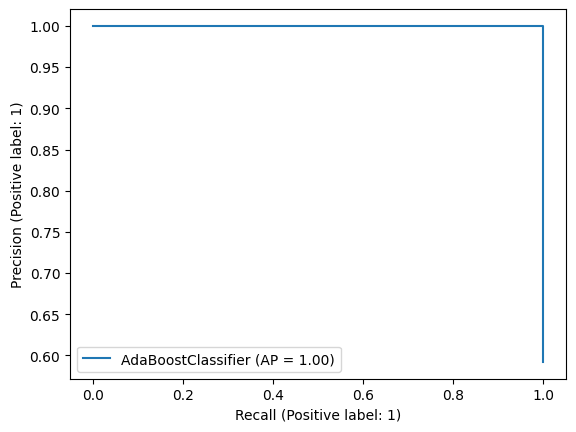

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(y_cnh_test, predictions, name="AdaBoostClassifier")
plt.show()

Análise de Precisão

**Precision**

Quando o modelo previu SIM, o quanto ele estava certo?
- 885 / (885 + 0) = 1,00
- Foi identificado pelo modelo corretamente 100% para renovação CNH no ano vigente.

Análise de Precisão

**Recall**
- 2170 / 2170 + 0) = 1,00
- Foi identificado pelo modelo corretamente 100% em toda a dataset para NAO renovação CNH no ano vigente.


In [ ]:
# Simulando a aplicação do modelo em dados não vistos
# Novos dados - não sabemos a classe!
#IDADE	CATEGORIA	TIPO	EMISSAO	VALIDADE	RENOVACAO
data = {'IDADE': [56],
        'CATEGORIA': ['B'],
        'TIPO':['C'],
        'EMISSAO': ['10/01/2019'],
        'VALIDADE':['10/01/2020'],
       }

atributos = ['IDADE','CATEGORIA','TIPO','EMISSAO','VALIDADE']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:5]

# Codificar variáveis categóricas
label_encoder_cat = LabelEncoder()
label_encoder_tipo = LabelEncoder()
label_encoder_emissao = LabelEncoder()
label_encoder_validade = LabelEncoder()


X_entrada[:,1] = label_encoder_cat.fit_transform(X_entrada[:,1])
X_entrada[:,2] = label_encoder_tipo.fit_transform(X_entrada[:,2])
X_entrada[:,3] = label_encoder_emissao.fit_transform(X_entrada[:,3])
X_entrada[:,4] = label_encoder_emissao.fit_transform(X_entrada[:,4])


# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[ 0.09837529 -2.86828005 -0.4010098  -1.58119773]]


In [ ]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

[0]


Optei por utiizar um dataset que fosse amigável no meu dia a dia, o que proporcionou a alteração e manipulação dos dados para N possibilidades e análise no comportamento dos modelos e resultado final.

Utilizei as pipelines: #random_forest, #gradient_boosting ,#bagging e #adaboost

O resultado que mais fez sentido foi utilizando o modelo adaboost que acertou 100% das possibilidades disponibilizadas.

Fiz o comparativo entre os modelos que estão comentados na otimização dos hiperparâmetros com N regras/datasets que contrui.

[texto do link](https://)